<a href="https://colab.research.google.com/github/nverchev/BettingNetworks/blob/main/EfficientNet/BettingNetworksEfficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Betting Networks
This notebook is an implementation of Betting Networks, a classifier that uses adversarial learning. It comprises a baseline and evaluation metrics.

In [ ]:
#@title Downloads and installs
!mkdir ./EfficientNet
!wget http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth -O./EfficientNet/efficientnet-b0-08094119.pth
!pip3 install --upgrade --quiet minio
!pip install "opencv-python-headless<4.3"
!pip install --quiet optuna
!pip install -q -U albumentations --quiet
!git clone https://github.com/nverchev/BettingNetworks.git


--2022-06-10 08:42:23--  http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.195.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21383481 (20M) [application/octet-stream]
Saving to: ‘./EfficientNet/efficientnet-b0-08094119.pth’

./EfficientNet/effi 100%[===================>]  20.39M  35.8MB/s    in 0.6s    

2022-06-10 08:42:24 (35.8 MB/s) - ‘./EfficientNet/efficientnet-b0-08094119.pth’ saved [21383481/21383481]

     |████████████████████████████████| 75 kB 3.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.5 MB/s 
     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 81 kB 8.7 MB/s 
     |█████████████████

In [ ]:
#@title Do not share!
# Optional for storing model remotely
from minio import Minio
# minioClient = Minio('???',
#                   access_key='???',
#                   secret_key='???',
#                   secure=True)
minioClient = None
dir_path = "./"

In [ ]:
#@title Libraries
import torch
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import json
import re
from torch import optim
import torch.cuda.amp as amp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from abc import ABCMeta,abstractmethod
import gc
from sklearn import metrics
import torchvision
from PIL import Image
from torchvision.datasets.cifar import CIFAR100 
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from PIL.Image import BICUBIC
from collections import OrderedDict
import optuna
import sys
sys.path.append('/content/BettingNetworks')
sys.path.append('/content/BettingNetworks/EfficientNet')
from dataset import get_dataset
from model import get_model
from trainer import get_trainer
from optimisation import get_opt
from Utils.Scheduling import CosineSchedule

In [ ]:
#@title Hyperparameters: { display-mode: "form" }
model_name = "BaselineClassifier"  #@param ['BaselineClassifier', 'BettingNetworks', 'BettingNetworksTwoHeaded']
loss_name = "BCE"  # @param ["BCE", "MAE", "MSE", "Naive", "Betting", "CrossBet"]
experiment = 'final'  # @param {type: "string"}
batch_size =  64  #@param {type: "number"}
epochs = 60  # @param {type: "integer"}
batch_size = 64  # @param {type: "integer"}
opt = 'SGD'  # @param ['Adam', 'AdamW', 'SGD', 'SGD_nesterov']
learning_rate = 0.001  # @param {type: "number"}
weight_decay = 0.0000  # @param {type: "number"}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, test_loader = get_dataset(experiment, batch_size, dirpath="./")
optimizer, optim_args = get_opt(model_name, opt, learning_rate, weight_decay)
block_args = {
    'optim_name': opt,
    'optim': optimizer,
    'optim_args': optim_args,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'test_loader': test_loader,
    'device': device,
    'batch_size': batch_size,
    'schedule': CosineSchedule(),
    'minioClient': minioClient,
    'dir_path': dir_path
}
for k, v in block_args.items():
    if not isinstance(v, (type, torch.utils.data.dataloader.DataLoader)):
        print(k, ': ', v)

model = get_model(model_name, experiment)
exp_name = '_'.join([model_name, experiment])
trainer = get_trainer(model, loss_name, exp_name, block_args)

Files already downloaded and verified
Files already downloaded and verified
optim_name :  SGD
optim_args :  {'weight_decay': 0.0, 'lr': {'stem': 0.0001, 'blocks': 0.0001, 'head': 0.0002, 'classifier': 0.001}}
val_loader :  None
device :  cuda:0
batch_size :  64
schedule :  CosineSchedule
minioClient :  <minio.api.Minio object at 0x7efd70280950>


Loaded:  ./BettingNetworks_class_imbalanced/model_epoch60.pt
Version  BettingNetworks_class_imbalanced


  0%|          | 0/157 [00:00<?, ?it/s]

Average test losses :
Book Loss: -0.0145	Bettor Loss: 0.0145	CEp: 0.4627	CEq: 0.4792	
Accuracy : 0.8827	Macro F1 Score : 0.8426	Macro Jaccard Score : 0.7373	Macro AUC ROC : 0.9939	
BettingNetworks_class_imbalanced
Max confidence


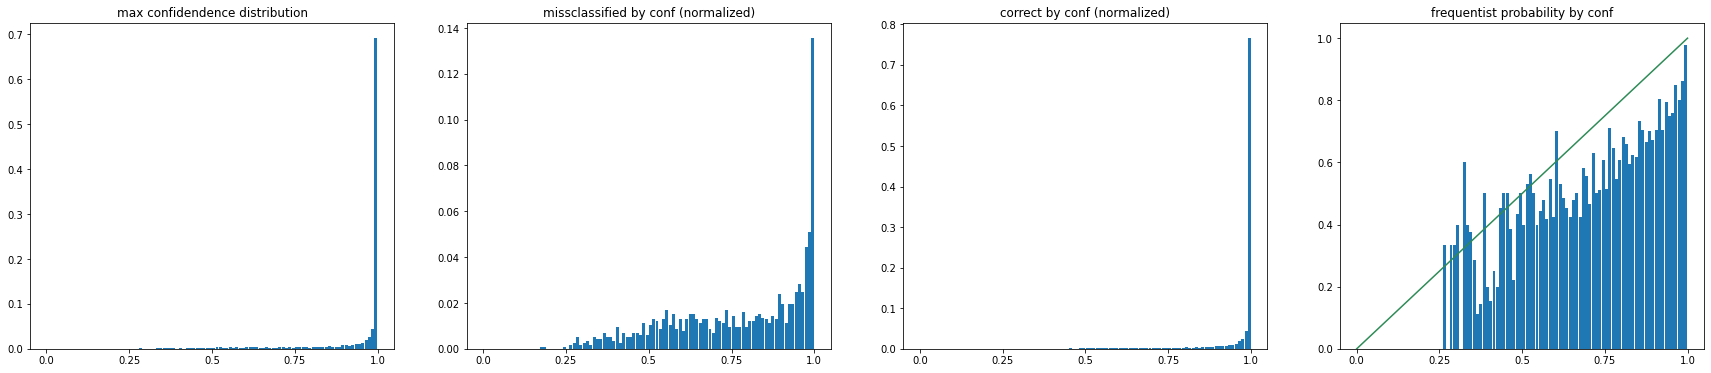

ECE_pred:  0.14784708909013053
ECE:  0.2791696434184072  Brier Score:  0.1837073415517807
Max conf quantile


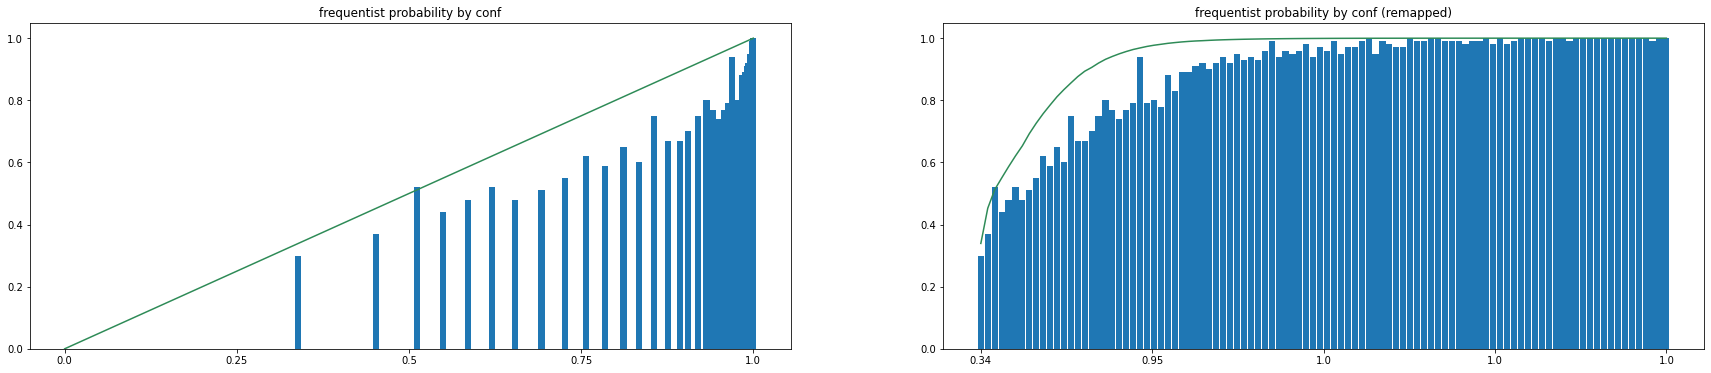

Quantile ECE_pred:  0.06036873906850815
Quantile ECE:  0.0025367564521729946


In [ ]:
trainer.load(60)
trainer.test(on="test")
trainer.prob_analysis()

Loaded:  ./BaselineClassifier_final/model_epoch60.pt
Version  BaselineClassifier_final


  0%|          | 0/157 [00:00<?, ?it/s]

Average test losses :
MSE: 13.7676	
Accuracy : 0.8522	Macro F1 Score : 0.8520	Macro Jaccard Score : 0.7502	Macro AUC ROC : 0.9974	
BaselineClassifier_final
Max confidence


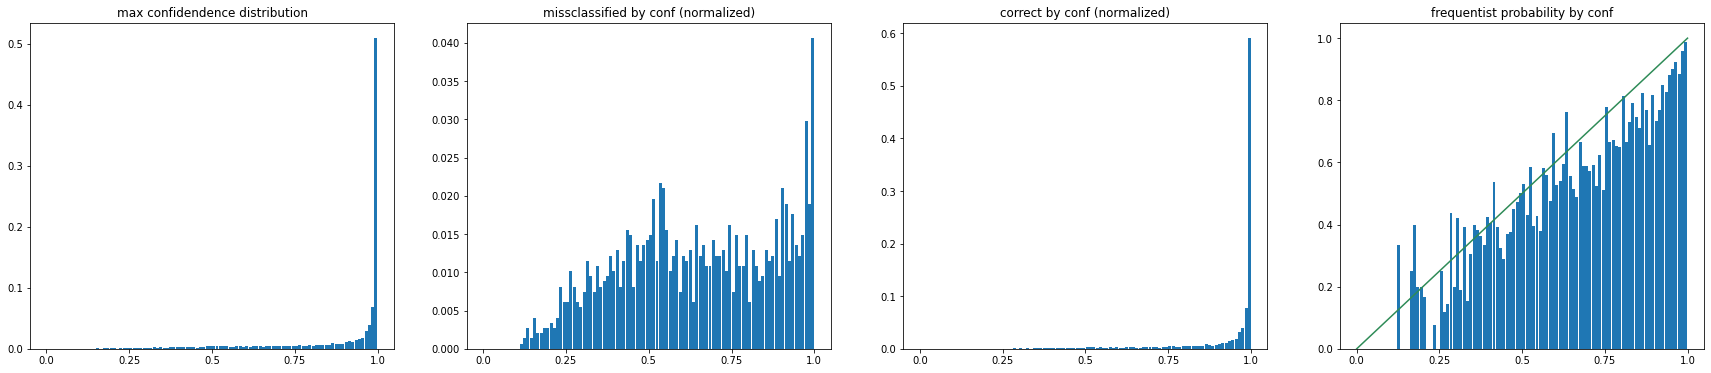

ECE_pred:  0.09751072688049144
ECE:  0.26651425683843116  Brier Score:  0.21615061163902283
Max conf quantile


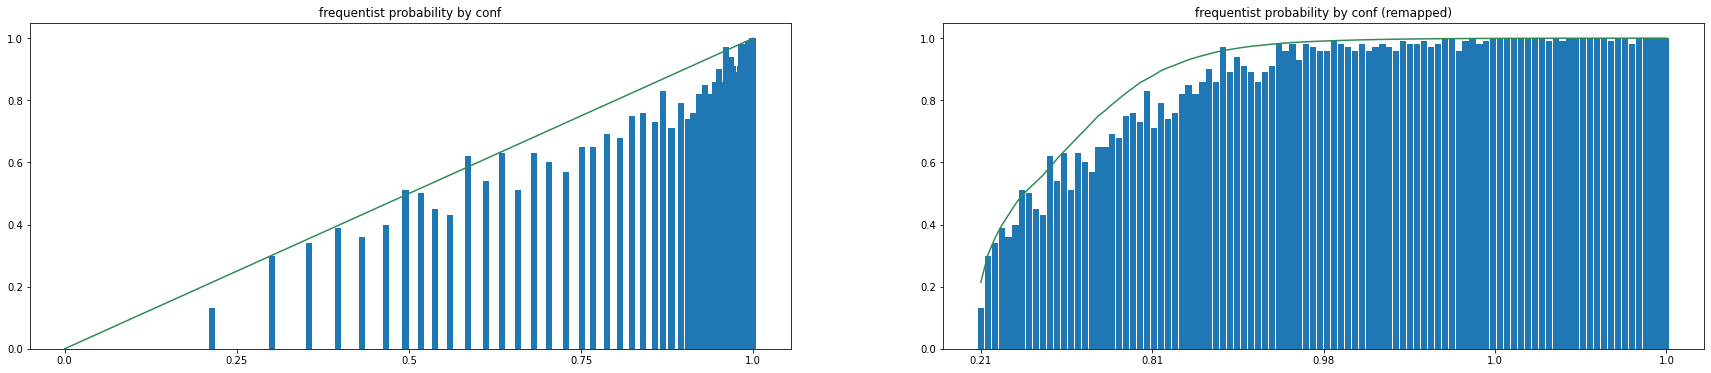

Quantile ECE_pred:  0.041176605969667435
Quantile ECE:  0.0012210466666147113


In [ ]:
#Baseline final epoch 60
trainer.load(60)
trainer.test(on="test")
trainer.prob_analysis()

Loaded:  ./BaselineClassifier_final/model_epoch60.pt
Version  BaselineClassifier_final


  0%|          | 0/157 [00:00<?, ?it/s]

Average test losses :
MSE: 13.7676	
Accuracy : 0.8522	Macro F1 Score : 0.8520	Macro Jaccard Score : 0.7502	Macro AUC ROC : 0.9974	
BaselineClassifier_final
Max confidence


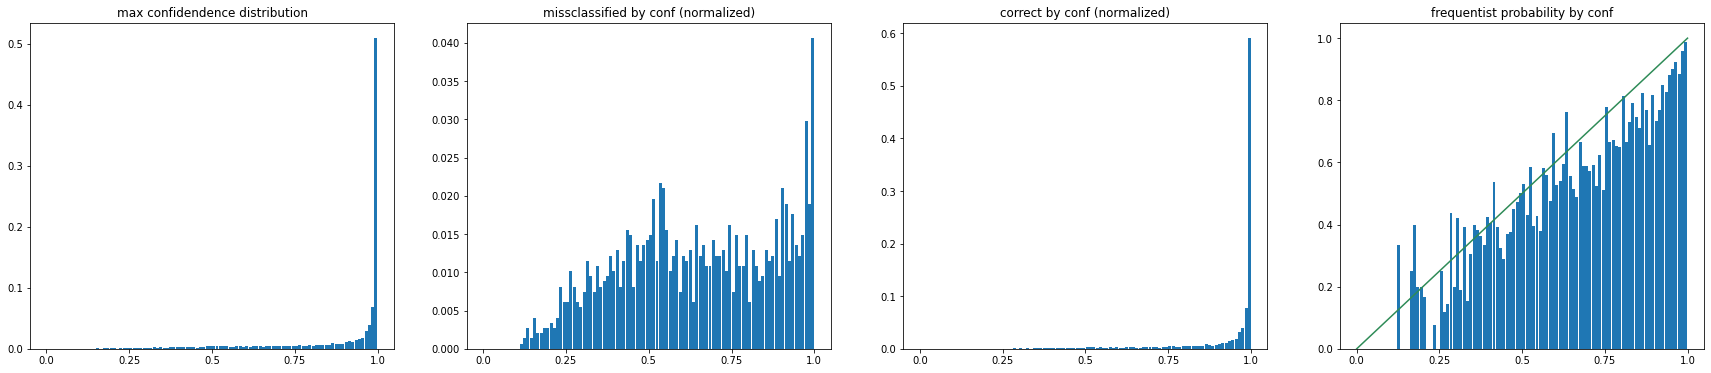

ECE_pred:  0.09751072688049144
ECE:  0.266514744595694  Brier Score:  0.21615058183670044
Max conf quantile


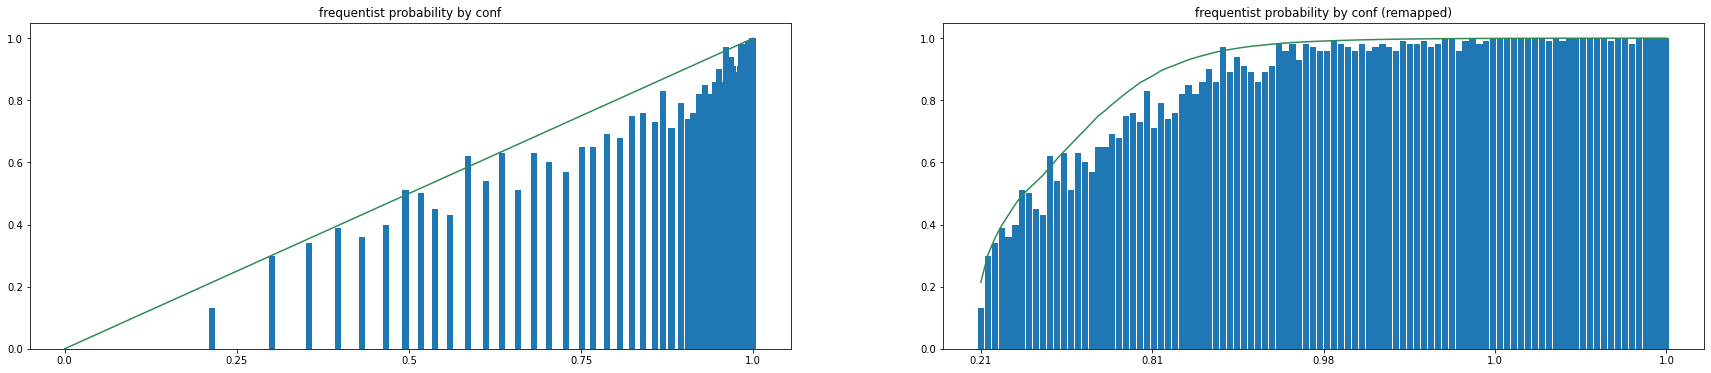

Quantile ECE_pred:  0.041176602244377136
Quantile ECE:  0.0012210465501993895


In [ ]:
#Baseline final epoch 60
trainer.load(60)
trainer.test(on="test")
trainer.prob_analysis()


Loaded:  ./BaselineClassifierfinal_nomomentum/model_epoch60.pt
Version  BaselineClassifierfinal_nomomentum


  0%|          | 0/157 [00:00<?, ?it/s]

Average test losses :
CE: 0.5553	
Accuracy : 0.8305	Macro F1 Score : 0.8299	Macro Jaccard Score : 0.7185	Macro AUC ROC : 0.9976	
BaselineClassifierfinal_nomomentum
Max confidence


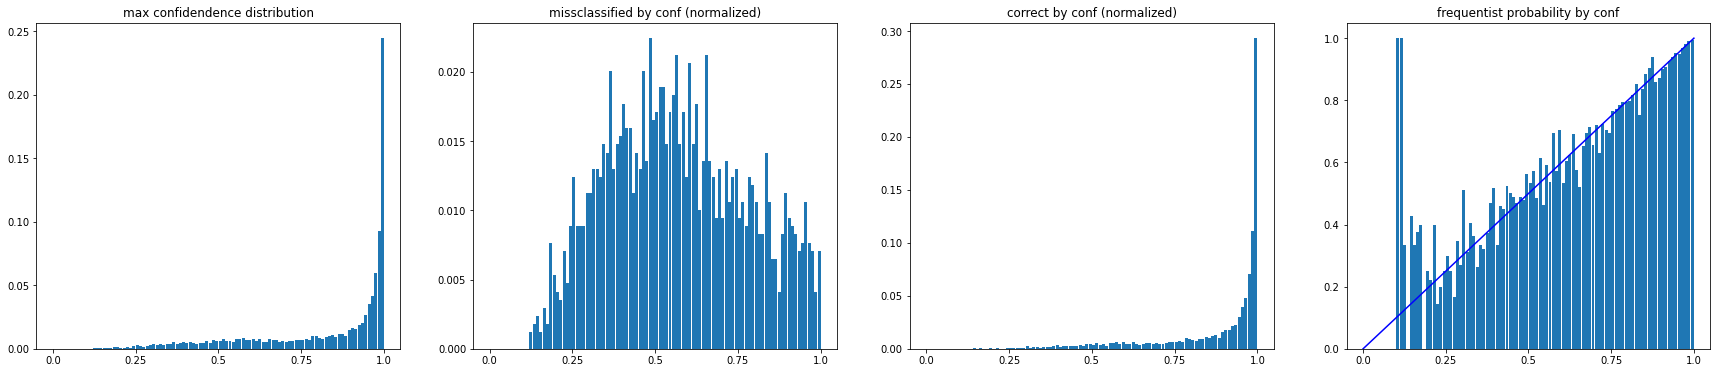

ECE_pred:  0.07275122548474204
ECE:  0.24618603041453072  Brier Score:  0.24199065566062927
Max conf quantile


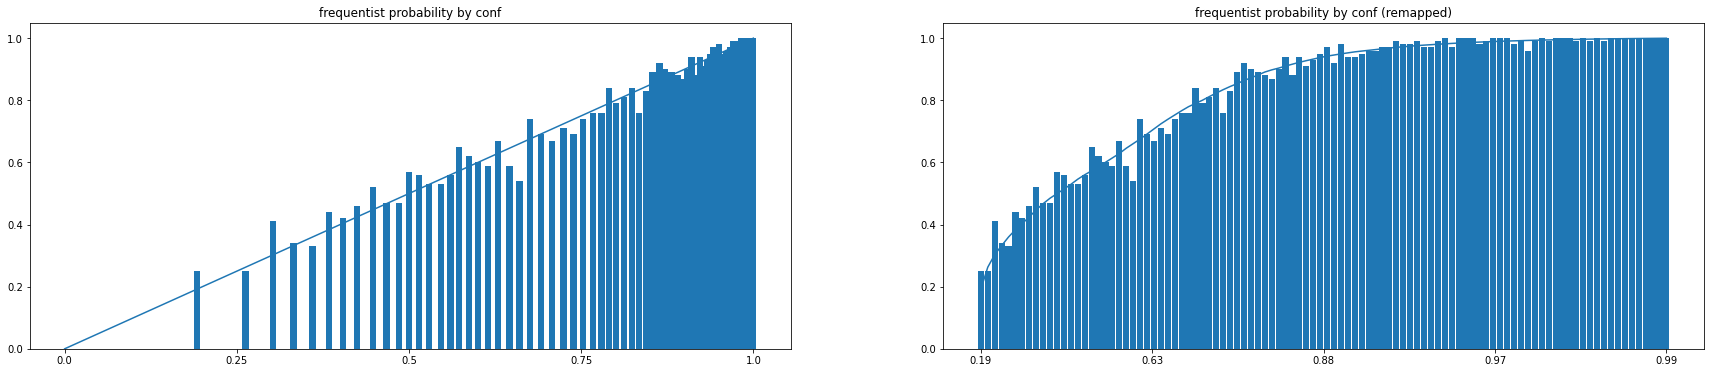

Quantile ECE_pred:  0.019913893193006516
Quantile ECE:  0.0011020670644938946


In [ ]:
#Baseline no momentum final epoch 60
trainer.load(60)
trainer.test(on="test")
trainer.prob_analysis()


Version  BettingNetworksTwoHeaded


  0%|          | 0/131 [00:00<?, ?it/s]

Average val losses :
Book Loss: -0.0067	Bettor Loss: 0.0067	CEp: 0.5535	CEq: 0.5683	
Accuracy : 0.8540	Macro F1 Score : 0.8529	Macro Jaccard Score : 0.7525	Macro AUC ROC : 0.9971	
BettingNetworksTwoHeaded
Max probs


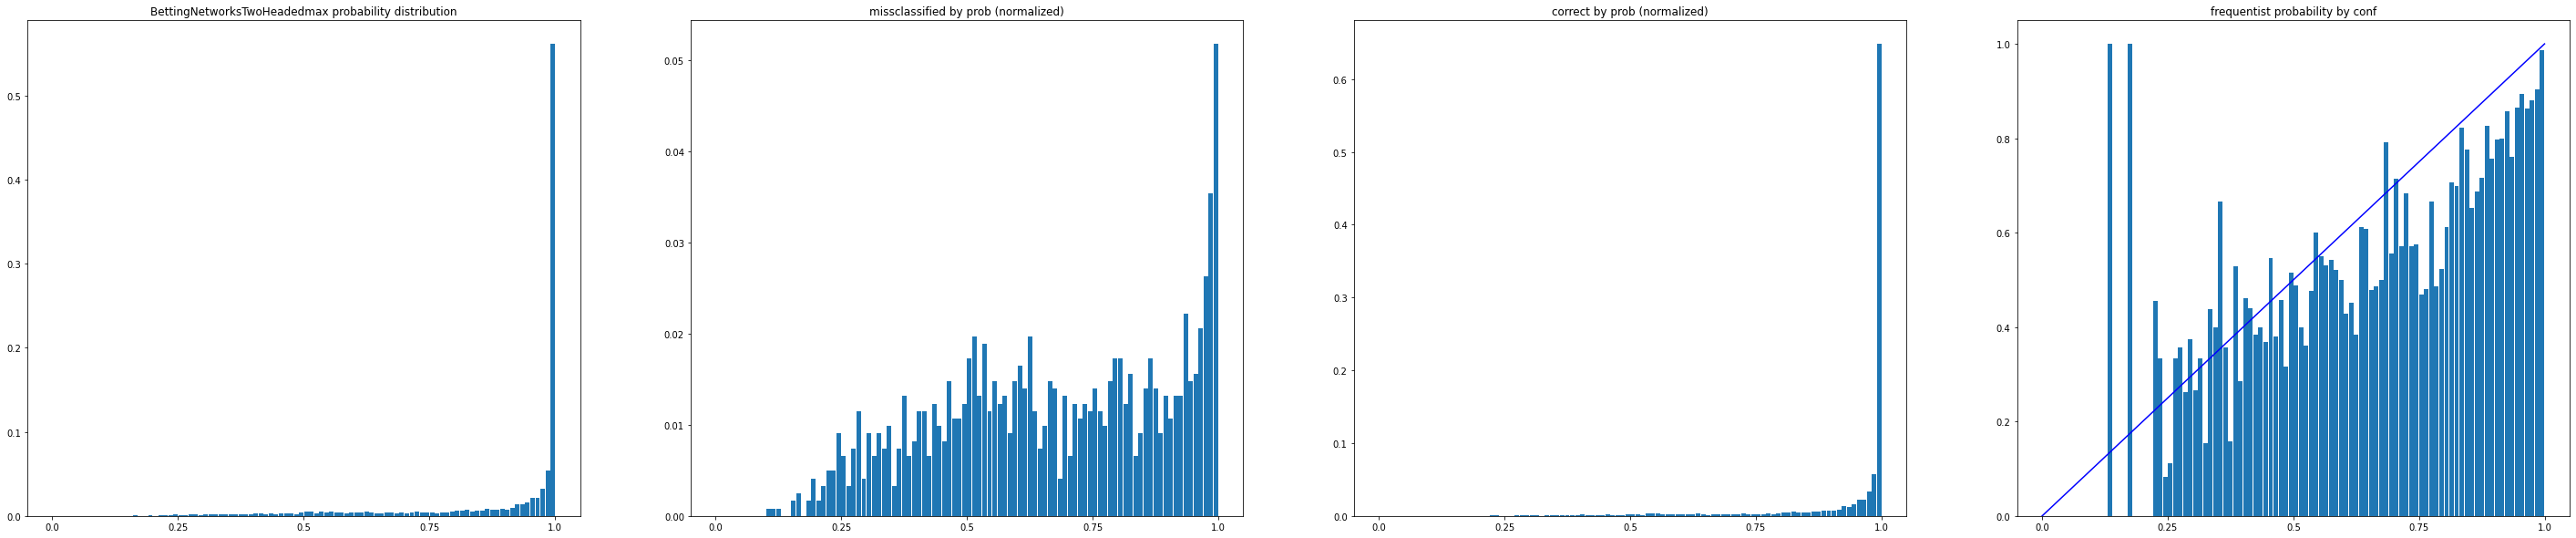

ECE_pred:  0.1326616245642137  Brier:  0.21910305321216583
ECE:  tensor(0.2661, dtype=torch.float64)


In [ ]:
trainer.test(on='val')
trainer.prob_analysis()



In [ ]:
#@title Baseline classifier hyperparameters optimization
trainer.save() #save initial setup
def objective(trial):
    trainer.load(0) 
    base_lr = trial.suggest_float("lr_init", 1e-3, 1e-1, log=True)
    print(f"New learning rate init = {base_lr}")
    lr = helper_lr(base_lr) # scales the learning rate proportionally
    trainer.update_learning_rate(lr)
    for step in range(10):
        trainer.train(1)
        intermediate_value = trainer.metrics['Accuracy']
        trial.report(intermediate_value, step) #only one check
        if trial.should_prune():
            raise optuna.TrialPruned()
    return trainer.metrics['Accuracy']

trainer.hypertuning_mode = True
study_name = 'tune_lr'  # Unique identifier of the study.
study = optuna.create_study(
                study_name=study_name,
                direction='maximize',
                pruner=optuna.pruners.MedianPruner(n_startup_trials=3,
                                                   n_warmup_steps=2))
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))